# Red Neuronal Cuántica para MNIST

- **Nombre:** Brayan Simon Polo Orellana
- **Github:** https://github.com/bspoloo/SIS421-022025

Para este ejercicio se realizará un simulador con PyTorch + GPU logrando hacer simulación cuántica, lo cual es útil para aprender, investigar y probar.
Creando un modelo para predecir numeros, entrenado con un dataset ``MNIST``.


## 1.- Introducción a Redes Neuronales Cuánticas

Las **Redes Neuronales Cuánticas (QNNs)** combinan principios de la mecánica cuántica con arquitecturas de redes neuronales.

La unidad fundamental es el **qubit**, que puede existir en una superposición de estados base:

$$
\lvert \psi \rangle = \alpha \lvert 0 \rangle + \beta \lvert 1 \rangle
$$

donde $\alpha, \beta \in \mathbb{C}$ son amplitudes de probabilidad que satisfacen la condición de normalización:

$$
\lvert \alpha \rvert^2 + \lvert \beta \rvert^2 = 1.
$$
---

### 1.- Importacion de librerias

In [ ]:
import torch                                # PyTorch 
import torch.nn as nn                       # Libreria de redes neuronales
import torch.optim as optim                 # Optimizadores
import torchvision                          # Libreria de vision por computadora
import torchvision.transforms as transforms # Transformaciones de datos
from torch.utils.data import DataLoader     # Cargador de datos
import matplotlib.pyplot as plt             # Libreria de graficos
import numpy as np                          # Libreria de calculo numerico

### 2.- Funcion para carga de datos del MNIST

Aplicamos varias transformaciones (normalización, aumento de datos y regularización), y devuelve dos DataLoader: uno para entrenamiento y otro para pruebas. Así puedes obtener lotes de imágenes y etiquetas listos para entrenar y evaluar modelos en PyTorch.

In [179]:
def load_mnist_data(batch_size=128):
    transform = transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Data augmentation
        transforms.RandomErasing(p=0.2)  # Regularización adicional
    ])
    
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

## 2.- QuantumEncodingLayer: Codificación Cuántica

### Objetivo
Transformar los **pixeles clásicos** de las imágenes en **estados cuánticos complejos** en el círculo unitario.

### Implementación
1. Proyección lineal:

$$
h = W x + b, \qquad x \in \mathbb{R}^{784}, \; h \in \mathbb{R}^{d_q}
$$

donde \(d_q = 256\) es la dimensión de la codificación cuántica.

2. Normalización y activación:

$$
h' = \tanh(\mathrm{LayerNorm}(h))
$$

3. Conversión a número complejo unitario:

$$
f_\phi(\phi) = \cos(\phi) + i\,\sin(\phi) \quad\text{(representación en el círculo unitario)}
$$
---

In [ ]:
class QuantumEncodingLayer(nn.Module):
    def __init__(self, input_dim, quantum_dim):
        super(QuantumEncodingLayer, self).__init__()
        self.input_dim = input_dim                              # Dimensión de entrada (tamaño del vector de características)
        self.quantum_dim = quantum_dim                          # Dimensión del espacio cuántico (número de qubits)

        # Capa lineal para encoding
        self.linear = nn.Linear(input_dim, quantum_dim)
        self.layer_norm = nn.LayerNorm(quantum_dim)
        self.dropout = nn.Dropout(0.2)
    
    def f_phi(self, phi):
        # Mapear características a estados cuánticos usando el mapa de características cuánticas
        return torch.complex(torch.cos(phi), torch.sin(phi))
    
    def forward(self, x):
        x = x.view(-1, self.input_dim)                          # Aplanar la entrada
        quantum_features = self.linear(x)                       # Capa lineal
        quantum_features = self.layer_norm(quantum_features)    # Normalización
        quantum_features = torch.tanh(quantum_features)         # Activación
        quantum_features = self.dropout(quantum_features)       # Dropout
        quantum_states = self.f_phi(quantum_features)           # Mapear a estados cuánticos
        return quantum_states                                   # Retornar estados cuánticos

### Resultado
Cada vector de entrada queda representado como un conjunto de **números complejos unitarios**, que simulamos como estados tipo $|\psi\rangle$.

---

## 3.- QuantumLayer: Neurona Cuántica

### Objetivo
Implementar una **neurona cuántica** con pesos, umbrales y fases, siguiendo las ideas del documento.

### Fórmulas principales

1. **Suma ponderada con pesos y umbral**:

$$
u = \sum_{k} \theta_k x_k - \lambda
$$

donde:
- $\theta_k$ son los pesos (matriz de parámetros),
- $\lambda$ es el umbral (threshold).

---

2. **Codificación en fase compleja**:

$$
f_\phi(\phi) = \cos(\phi) + i \sin(\phi)
$$

---

3. **Argumento (fase) de un número complejo**:

$$
\arg(u) = \text{atan2}(\Im(u), \Re(u))
$$

---

4. **Función de activación cuántica (sigmoide aplicada a $\delta$):**

$$
g(\delta) = \frac{1}{1 + e^{-\delta}}
$$

---

5. **Salida (fase ajustada):**

$$
y = \frac{\pi}{2} \cdot g(\delta) - \arg(u)
$$

La salida final puede representarse como un número complejo en la circunferencia:

$$
z = f_\phi(y) = \cos(y) + i \sin(y)
$$

---

En el código usamos además normalización y dropout sobre la parte real de $y$ para alimentar las capas clásicas.


In [ ]:
class QuantumLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(QuantumLayer, self).__init__()
        self.input_dim = input_dim      # Dimensión de entrada (número de qubits)
        self.hidden_dim = hidden_dim    # Dimensión oculta (número de qubits en la capa oculta)

        # Parámetros cuánticos
        self.theta = nn.Parameter(torch.randn(hidden_dim, input_dim) * 0.05) # Pesos inicializados cerca de cero
        self.lamda_params = nn.Parameter(torch.zeros(hidden_dim))            # Umbrales inicializados en cero
        self.delta_params = nn.Parameter(torch.ones(hidden_dim) * 0.5)       # Parámetros delta inicializados en 0.5
        
        # Regularización
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.3)

    def f_phi(self, phi):
        return torch.complex(torch.cos(phi), torch.sin(phi)) # Mapear a números complejos unitarios
    
    def sigmoid_quantum(self, x):
        return 1 / (1 + torch.exp(-x)) # Función sigmoide
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Operaciones cuánticas
        theta_expanded = self.f_phi(self.theta).unsqueeze(0) # (1, hidden_dim, input_dim)
        x_expanded = x.unsqueeze(1) # (batch_size, 1, input_dim)
        
        weighted_sum = torch.sum(theta_expanded * x_expanded, dim=-1) # (batch_size, hidden_dim)
        threshold = self.f_phi(self.lamda_params).unsqueeze(0) # (1, hidden_dim)
        u = weighted_sum - threshold
        
        arg_u = torch.atan2(u.imag, u.real) # Argumento de u
        g_delta = self.sigmoid_quantum(self.delta_params).unsqueeze(0) # (1, hidden_dim)
        y = (torch.pi/2) * g_delta - arg_u
        
        # Procesamiento adicional
        y_real = y.realm # Tomar la parte real
        y_real = self.layer_norm(y_real) # Normalización
        y_real = self.dropout(y_real) # Dropout
        
        z = self.f_phi(y) # Mapear a números complejos unitarios
        return z, y_real


## 4.- QNN_MNIST: Arquitectura Completa

### Flujo de datos
1. Imagen MNIST (28 × 28 → vector de 784).  
2. **QuantumEncodingLayer**: proyección → números complejos unitarios.  
3. **QuantumLayer**: suma ponderada, fase, activación → devuelve $z$ (complejo) y $y_{\text{real}}$.  
4. Capas clásicas (Linear → ReLU → Linear) → salida de 10 clases.  
5. Softmax / CrossEntropy para entrenamiento.

### Expresión compacta del bloque clásico final

Si $y_{\text{real}}$ es la salida real de la capa cuántica, el bloque clásico realiza:

$$
\hat{y} = \operatorname{Softmax}\!\bigl(W_2\ \sigma(W_1\ y_{\text{real}} + b_1) + b_2\bigr)
$$

donde $\sigma$ es la activación ReLU.

### Notas
- $W_1 \in \mathbb{R}^{h\times d}$ y $W_2 \in \mathbb{R}^{C\times h}$ son las matrices de peso clásicas (con $d$ la dimensión de entrada y $C=10$ las clases).  
- La función Softmax produce probabilidades $\hat{y}_i$:

$$
\hat{y}_i = \frac{\exp(s_i)}{\sum_{j=1}^{C}\exp(s_j)},\qquad s = W_2\ \sigma(W_1\ y_{\text{real}} + b_1) + b_2.
$$

- Para entrenamiento se usa Cross-Entropy Loss sobre $\hat{y}$ (ver sección de entrenamiento).



In [ ]:
class QNN_MNIST(nn.Module):
    def __init__(self):
        super(QNN_MNIST, self).__init__()
        self.input_dim = 28 * 28 # Dimensión de entrada (tamaño del vector de características)
        self.quantum_dim = 256 # Dimensión del espacio cuántico (número de qubits)
        self.hidden_dim = 128 # Dimensión oculta (número de qubits en la capa oculta)
        self.output_dim = 10 # Número de clases (dígitos del 0 al 9)
    
        # Encoding cuántico
        self.quantum_encoder = QuantumEncodingLayer(self.input_dim, self.quantum_dim) # Capa de encoding cuántico
        self.quantum_layer = QuantumLayer(self.quantum_dim, self.hidden_dim) # Capa cuántica
        
        # Capas clásicas
        self.classical_fc1 = nn.Linear(self.hidden_dim, 64)
        self.classical_fc2 = nn.Linear(64, self.output_dim)
        
        # Regularización
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.3)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = x.view(-1, self.input_dim)
        
        # Encoding cuántico
        quantum_states = self.quantum_encoder(x)
        
        z, y_real = self.quantum_layer(quantum_states) # Capa cuántica que retorna estados y características reales
        
        # Capas clásicas adicionales
        features = self.dropout1(y_real)
        features = self.activation(self.classical_fc1(features))
        features = self.dropout2(features)
        output = self.classical_fc2(features)
        
        return output

## 5.- Entrenamiento y Evaluación

### Normalización del dataset
Para MNIST se aplica la normalización estándar:

$$
x' = \frac{x - 0.1307}{0.3081}
$$

### Función de pérdida
Se usa Cross-Entropy Loss para clasificación multiclase:

$$
\mathcal{L}(\theta) = -\sum_{i=1}^{10} y_i \log(\hat{y}_i)
$$

### Optimizador
Se emplea AdamW con weight decay:

Actualización de parámetros (esquema):

$$
\theta \leftarrow \theta - \eta \, \hat{m}_t / (\sqrt{\hat{v}_t} + \epsilon) - \eta \cdot \lambda_{\mathrm{decay}} \cdot \theta
$$

(forma general del paso de AdamW; PyTorch lo maneja internamente).

### Técnicas extra
- **Gradient clipping** para evitar explosión de gradientes.  
- **ReduceLROnPlateau** para bajar lr si no mejora el accuracy.  
- **Early stopping** por paciencia.

---



In [184]:
def evaluate_model(model, test_loader, device):
    """Evaluar el modelo en el conjunto de test"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    return 100. * correct / total

In [185]:
def train_improved_qnn(model, train_loader, test_loader, num_epochs=30, learning_rate=0.0005):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    # Optimizador mejorado
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5, verbose=True
    )
    
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    best_accuracy = 0
    patience_counter = 0
    patience = 10
    
    print("Iniciando entrenamiento de QNN mejorada en MNIST...")
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1} [{batch_idx * len(data)}/{len(train_loader.dataset)}] '
                      f'Loss: {loss.item():.4f}')
        
        train_acc = 100. * correct / total
        test_acc = evaluate_model(model, test_loader, device)
        
        # Actualizar scheduler
        scheduler.step(test_acc)
        
        # Early stopping
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            patience_counter = 0
        else:
            patience_counter += 1
        
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {train_losses[-1]:.4f}, '
              f'Train Acc: {train_acc:.2f}%, '
              f'Test Acc: {test_acc:.2f}%, '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    return model, train_losses, train_accuracies, test_accuracies


In [ ]:
# Hyperparámetros
learning_rate = 0.0005  # Learning rate
num_epochs = 50         # Numero de épocas
batch_size = 64         # Batch size

model = QNN_MNIST()
train_loader, test_loader = load_mnist_data(batch_size)

trained_model, train_losses, train_accuracies, test_accuracies = train_improved_qnn(
    model, train_loader, test_loader, num_epochs, learning_rate
)

d:\Programs\Python\3.12.7\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Iniciando entrenamiento de QNN mejorada en MNIST...
Epoch: 1 [0/60000] Loss: 2.3307
Epoch: 1 [6400/60000] Loss: 2.1020
Epoch: 1 [12800/60000] Loss: 1.7427
Epoch: 1 [19200/60000] Loss: 1.3094
Epoch: 1 [25600/60000] Loss: 1.2828
Epoch: 1 [32000/60000] Loss: 0.8721
Epoch: 1 [38400/60000] Loss: 0.8063
Epoch: 1 [44800/60000] Loss: 0.8448
Epoch: 1 [51200/60000] Loss: 0.9621
Epoch: 1 [57600/60000] Loss: 0.7272
Epoch 1/50: Train Loss: 1.2165, Train Acc: 59.43%, Test Acc: 86.21%, LR: 0.000500
Epoch: 2 [0/60000] Loss: 0.6051
Epoch: 2 [6400/60000] Loss: 0.6101
Epoch: 2 [12800/60000] Loss: 0.5756
Epoch: 2 [19200/60000] Loss: 0.6816
Epoch: 2 [25600/60000] Loss: 0.6163
Epoch: 2 [32000/60000] Loss: 0.6975
Epoch: 2 [38400/60000] Loss: 0.6223
Epoch: 2 [44800/60000] Loss: 0.6781
Epoch: 2 [51200/60000] Loss: 0.6358
Epoch: 2 [57600/60000] Loss: 0.7143
Epoch 2/50: Train Loss: 0.6347, Train Acc: 79.76%, Test Acc: 88.06%, LR: 0.000500
Epoch: 3 [0/60000] Loss: 0.5432
Epoch: 3 [6400/60000] Loss: 0.5512
Epoch: 

## 6.- Visualizacion de resultados

In [189]:
def visualize_results(model, train_losses, train_accuracies, test_accuracies, device):
    """Visualizar resultados del entrenamiento"""
    # Crear figura con 2 filas y 2 columnas para los gráficos principales
    # y luego otra figura para las imágenes
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # Gráfico 1: Pérdida (arriba izquierda)
    ax1.plot(train_losses)
    ax1.set_title('Pérdida durante el entrenamiento')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    
    # Gráfico 2: Precisión (arriba derecha)
    ax2.plot(train_accuracies, label='Train Accuracy')
    ax2.plot(test_accuracies, label='Test Accuracy')
    ax2.set_title('Precisión durante el entrenamiento')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    # Ocultar los ejes 3 y 4 que no usaremos
    ax3.set_visible(False)
    ax4.set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Crear una figura separada para las imágenes de ejemplo
    plt.figure(figsize=(12, 6))
    plt.suptitle('Ejemplos de predicción en MNIST', fontsize=16)
    
    # Cargar datos de test (pequeño batch)
    _, test_loader_temp = load_mnist_data(batch_size=12)  # 12 ejemplos para 3x4 grid
    data_iter = iter(test_loader_temp)
    images, labels = next(data_iter)
    
    # Mover imágenes al mismo dispositivo que el modelo
    images = images.to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, predicted = outputs.max(1)
    
    # Mover de vuelta a CPU para visualización
    images = images.cpu()
    predicted = predicted.cpu()
    labels = labels.cpu()
    
    # Mostrar 12 ejemplos en grid 3x4
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        # Color verde si es correcto, rojo si es incorrecto
        color = 'green' if predicted[i] == labels[i] else 'red'
        plt.title(f'True: {labels[i]}, Pred: {predicted[i]}', color=color, fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

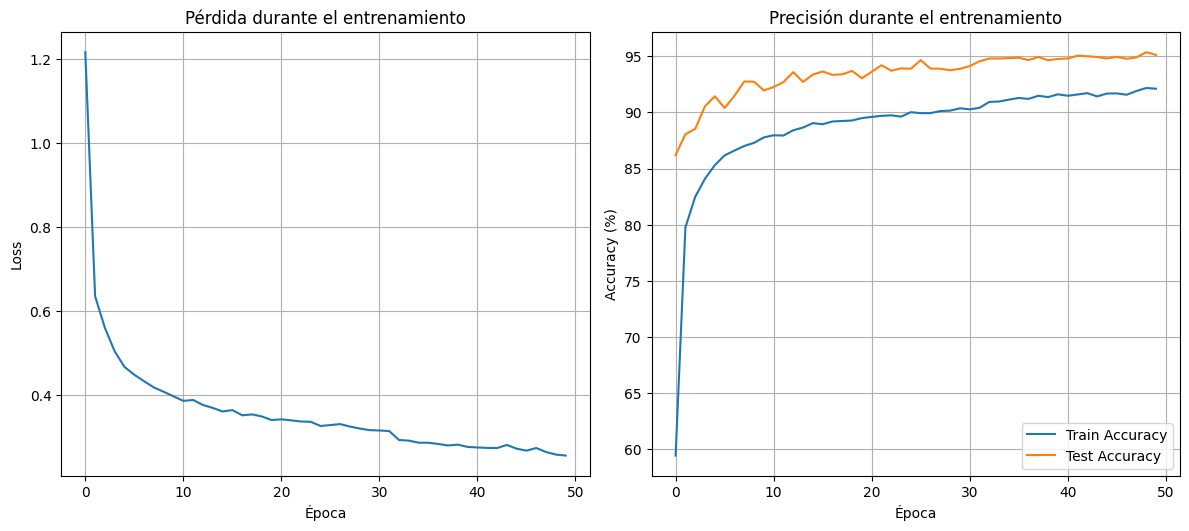

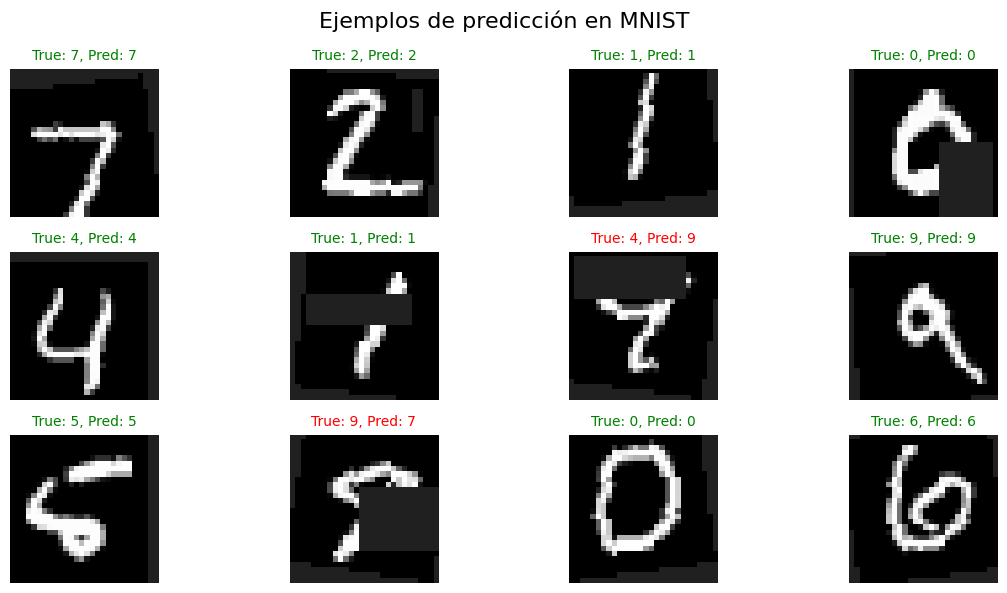

In [190]:
visualize_results(trained_model, train_losses, train_accuracies, test_accuracies, torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [191]:
# Liberar memoria de la GPU
import gc


if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    
    gc.collect()
    